The previous notebooks have been concerned with computing and selecting features for training, but now we are finally ready to build a model for predicting trail difficulty. Let's load our training and testing datasets and look at a few rows.

In [1]:
import pandas as pd

filename_train='../Data/hiking_train.csv'
filename_test='../Data/hiking_test.csv'
df_train=pd.read_csv(filename_train)
df_test=pd.read_csv(filename_test)

df_train.head()

,Length,Elevation gain,Rocky,Stairs,Muddy,Roots,Avg_grade,Difficulty,Max_grade,PC1,PC2,PC3
0,4.3,1489,1,0,0,0,0.065583,5.898734,0.437323,9.677791e+08,-1.470110e+08,6.834277e+06
1,4.7,705,1,1,0,0,0.028409,3.869565,0.465672,-1.702746e+08,5.713342e+06,-6.630057e+04
2,1.8,534,1,1,0,0,0.056187,4.327273,0.618551,-1.493663e+08,3.723912e+06,-7.795148e+05
3,3.5,508,1,0,0,0,0.027489,3.111498,0.371079,-1.564175e+08,5.284983e+06,-5.060873e+05
4,3.5,380,0,0,0,1,0.020563,3.005025,0.244496,-1.713756e+08,4.753831e+06,-6.157738e+05


Recall that our Difficulty is our target column, so we will set this to y while dropping it from x. We will also retain a list of the training feature names that will come in handy later.

In [2]:
import numpy as np

y_train=np.asarray(df_train['Difficulty'])
y_test=np.asarray(df_test['Difficulty'])
x_train=np.asarray(df_train.drop('Difficulty',axis=1))
x_test=np.asarray(df_test.drop('Difficulty',axis=1))

features=df_test.drop('Difficulty',axis=1).columns

For this project I will be using eXtreme Gradient Boosting (XGBoost), a powerful machine learning method based on decision trees. It's highly scalable, so if this dataset ever became large it would still be a good approach. In order to get the best model that we can, it is highly necessary to tune the values of its hyperparameters to the training data. The hyperparameters we will be tuning are:
1. max_depth: the maximum depth for each decision tree. Higher values offer more complexity but may overfit
2. min_child_weight: the minimum sum of instance weights in a child node. Higher values are more conservative but may prevent overfitting
3. gamma: minimum loss reduction required to make a further partition on a leaf node. Higher values are more conservative
4. colsample_bytree: fraction of features used when constructing each tree. Lower values may prevent overfitting
5. subsample: fraction of samples used to train each tree. Lower values may prevent overfitting
6. reg_alpha: L1 regularization term. Higher values are more conservative
7. reg_lambda: L2 regularization term. Higher values are more conservative

I found Aarshay Jain's [guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) on XGBoost hyperparameter tuning to be quite helpful. It recommends a set of sequential grid searches using cross-validation to identify optimal hyperparameter values. His example problem was a classification problem, but we can easily extend the method to regression problems by changing the objective (i.e., the loss function). We'll start by optimizing max_depth and min_child_weight. I'll use 5-fold cross-validation and a negative root mean squared error scoring criterion since it will mitigate large errors. I'll also limit the max_depth maximum value to 5 since we're working with a small dataset and thus we want to limit model complexity.

One quick note: for many machine learning techniques such as neural networks and Gaussian processes it is necessary to scale inputs prior to building the model. However, XGBoost is a scale-invariant method, so this step may be skipped in this case.

In [3]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_test1 = {
  'max_depth':range(1,5),
  'min_child_weight':range(1,12)
 }

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=42), 
param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch1.fit(x_train,y_train)

print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 4, 'min_child_weight': 2}
-0.6701632603980417


Next we'll optimize gamma.

In [4]:
param_test2 = {
'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.05, n_estimators=500, max_depth=gsearch1.best_params_['max_depth'],
min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=42), 
param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch2.fit(x_train,y_train)

print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'gamma': 0.4}
-0.6609189196744534


Next are colsample_bytree and subsample.

In [5]:
param_test3 = {
'subsample':[i/10.0 for i in range(5,10)],
'colsample_bytree':[i/10.0 for i in range(5,10)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.05, n_estimators=500, max_depth=gsearch1.best_params_['max_depth'],
min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=gsearch2.best_params_['gamma'], subsample=0.8, colsample_bytree=0.8,
objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=42), 
param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch3.fit(x_train,y_train)

print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'colsample_bytree': 0.5, 'subsample': 0.8}
-0.6272414729537477


Finally, we optimize reg_alpha and reg_lambda.

In [6]:
param_test4 = {
'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100],
'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.05, n_estimators=500, max_depth=gsearch1.best_params_['max_depth'],
min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=gsearch2.best_params_['gamma'], subsample=gsearch3.best_params_['subsample'], 
colsample_bytree=gsearch3.best_params_['colsample_bytree'],objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=42), 
param_grid = param_test4, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
gsearch4.fit(x_train,y_train)

print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'reg_alpha': 0, 'reg_lambda': 0.1}
-0.6240168389757204


Now we will define our final XGBoost model, using our optimized hyperparameter values while lowering the learning rate and increasing the number of estimators for best performance.

In [7]:
xgb=XGBRegressor(learning_rate =0.01, n_estimators=5000, max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=gsearch2.best_params_['gamma'], 
 subsample=gsearch3.best_params_['subsample'], colsample_bytree=gsearch3.best_params_['colsample_bytree'],
 reg_alpha=gsearch4.best_params_['reg_alpha'],reg_lambda=gsearch4.best_params_['reg_lambda'],objective= 'reg:squarederror', nthread=4,
 scale_pos_weight=1,seed=42)

With the model defined, we are ready to train and predict. When predicting, I will put in "guard rails" such that predictions smaller than 1 will be revised to 1 and predictions larger than 10 will be revised to 10. This is because the minimum possible difficulty score is 1 (i.e., if 100% of reviewers rate the trail as easy) and the maximum possible difficulty score is 10 (i.e., if 100% of reviewers rate the trail as strenuous).

In [8]:
xgb=xgb.fit(x_train,y_train)
preds_train=xgb.predict(x_train)
preds_test=xgb.predict(x_test)

#Constrain range of predictions to be between 1 and 10
preds_train[np.where(preds_train<1)[0]]=1
preds_train[np.where(preds_train>10)[0]]=10
preds_test[np.where(preds_test<1)[0]]=1
preds_test[np.where(preds_test>10)[0]]=10

Now let's evaluate model performance over the training and testing sets. We'll look at r<sup>2</sup>, mean absolute error, and root mean squared error.

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

r2_train=r2_score(y_train,preds_train)
r2_test=r2_score(y_test,preds_test)
mae_train=mean_absolute_error(y_train,preds_train)
mae_test=mean_absolute_error(y_test,preds_test)
rmse_train=root_mean_squared_error(y_train,preds_train)
rmse_test=root_mean_squared_error(y_test,preds_test)

print(r2_train)
print(r2_test)
print(mae_train)
print(mae_test)
print(rmse_train)
print(rmse_test)

0.9521970068343641
0.7199501600772623
0.18540498021101476
0.3797083321048441
0.23834755411090575
0.5018085707346579


Our testing errors are consistently higher than our training errors, but not to an extent that suggests problematic overfitting. Our problem is tricky: the targets are inherently noisy as they are based on human opinion. Remember that the targets are weighted averages, and these can be sensitive to small sample sizes (the smallest sample size in the dataset was 24 reviews). We're also assuming that the reviewers for each trail are drawn from the same underlying distribution, which may not be true! Some trails quite likely attract different sorts of hikers than others do, and that can affect how the difficulty of the hike is rated. There could even be some cases of mistaken identity, where a reviewer submits a review for a similarly-named but different trail than the one they actually hiked (e.g., Amicalola Falls vs. Amicalola Falls Loop). So the fact that our model is only off by about 0.38 on average is pretty good, especially when you remember that consecutive categorical labels (easy, moderate, etc.) are separated by a value of 3 in our difficulty rating system.

Let's make a plot of predictions vs. targets for the testing data.

Text(0.5, 1.0, 'Hiking trail difficulty')

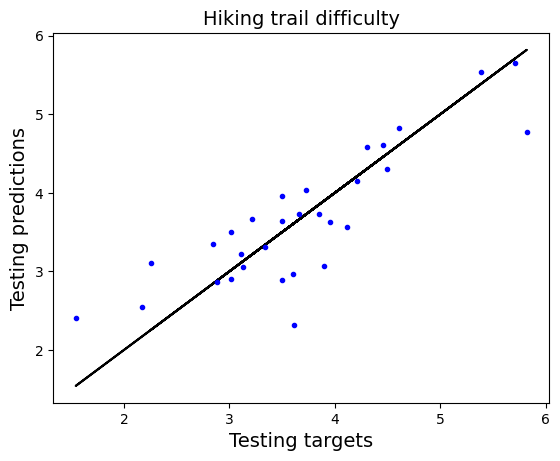

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test,y_test,'k')
plt.plot(y_test,preds_test,'b.')
plt.xlabel('Testing targets',fontsize=14)
plt.ylabel('Testing predictions',fontsize=14)
plt.title('Hiking trail difficulty',fontsize=14)

In general, the errors are lowest in intermediate regions, where more data points are represented. The model tends to over-predict difficulty for very low-difficulty and under-predict difficulty for very high-difficulty hikes. Adding more training data in the higher and lower regions of the difficulty range would most likely improve model performance in those areas.

Now let's create a histogram of the testing residuals to see how the errors are distributed.

Text(0, 0.5, 'Count')

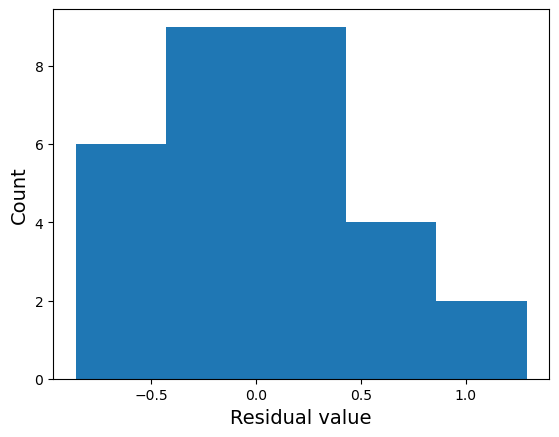

In [11]:
residuals_test=y_test-preds_test

plt.figure()
plt.hist(residuals_test,bins=5)
plt.xlabel('Residual value',fontsize=14)
plt.ylabel('Count',fontsize=14)

Note that based on the definition of a residual, positive residual values correspond to under-prediction while negative residual values correspond to over-prediction. From examination we see that the vast majority of the residuals fall between -0.5 and 0.5, with a much smaller number having a magnitude between 0.5 and 1.5. The largest residuals in this case correspond to under-prediction of more difficult trails.

One of the nice features of XGBoost is that it's easy to visualize the importance of input features. The xgboost package includes a built-in method for understanding how much each feature contributed to the model's structure during training.

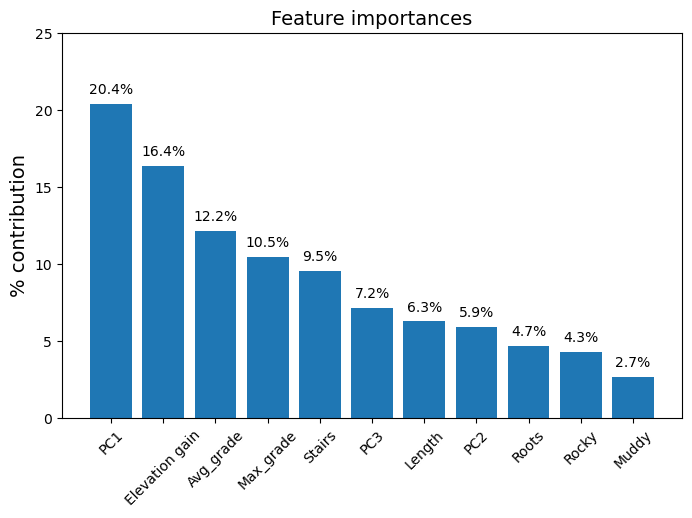

In [12]:
importances=100*xgb.feature_importances_

sorted_importances, sorted_features = zip(*sorted(zip(importances, features), reverse=True)) #sort in descending order for bar chart

fig, ax = plt.subplots(figsize=(8, 5))
bars=ax.bar(sorted_features, sorted_importances)
ax.bar_label(bars, fmt='%.1f%%',padding=5)
ax.set_ylabel('% contribution', fontsize=14)
ax.set_title('Feature importances',fontsize=14)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(0,25)
plt.show()

However, if we wish to understand feature importance with respect to model predictions or the directionality of feature influence, we need to use a different method. For this purpose we'll use Shapley Additive Explanations (SHAP), a game-theoretic approach that is commonly used to explain tree-based models and neural networks. We'll start by making a plot similar to the last one, but here the size of the bars will be correspond to the amount of contribution to testing predictions.

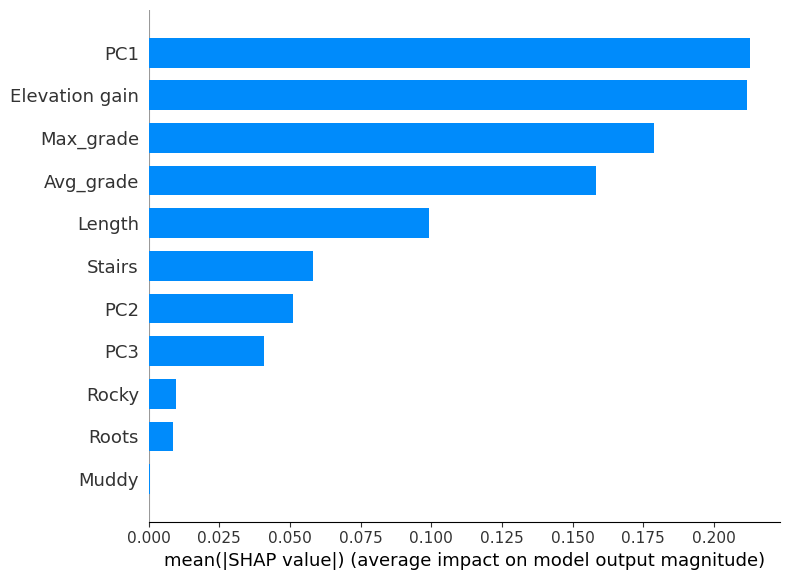

In [13]:
import shap

X_test=pd.DataFrame(x_test,columns=features)

shap_values = shap.TreeExplainer(xgb).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

From these results, we can see that elevation gain was the single most explanatory variable, which is not surprising and is also the top feature in xgboost's importances. The max grade, PC1, and average grade were also highly influential to the predictions. Curiously, the length of the hike made a much smaller contribution to the predictions, although we note that the longest hikes also have high elevation gain values, so there could be some confounding between the two variables. The muddy variable made no contribution to the predictions at all, so it can probably be removed for future analyses.

Now let's say we want to understand the directionality in addition to the size of the feature contributions. SHAP supports this functionality, and we'll show these relationships with a beeswarm plot.

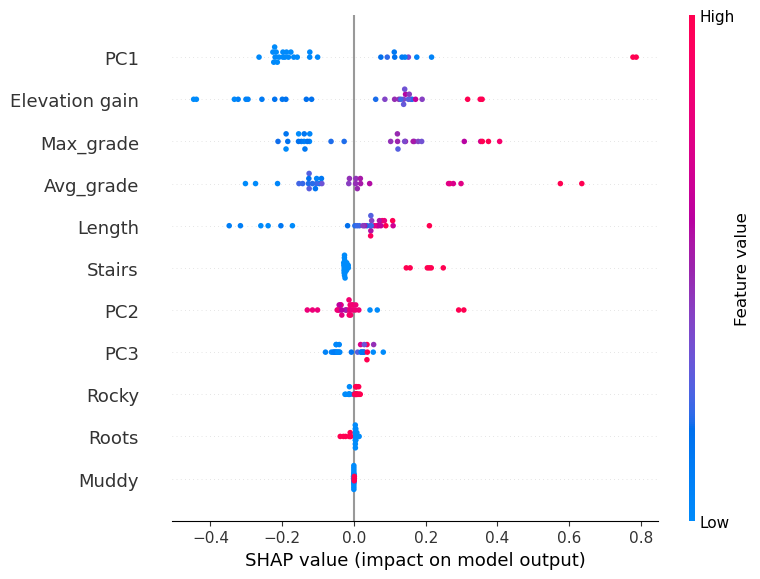

In [14]:
shap.summary_plot(shap_values, X_test)

Many of the features show a clear pattern. As elevation gain, average grade, and max grade increase, the model predicts higher hike difficulty, which is what we would expect. PC1 also shows a clear pattern, as the highest values provide a large contribution to hike difficulty. The only binary feature that made a significant contribution was the stairs variable, as the presence of stairs added between 0.05 and 0.1 to the difficulty rating.

It's important to mention that SHAP analysis only seeks to explain the contribution of feature values to model predictions. It does *not* attempt to explain the underlying causal relationships between inputs and outputs (see this [post](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html) for more details). For example, in our case we can see that the roots variable is slightly negatively correlated with hike difficulty: this does not necessarily mean that the presence of tree roots on a trail makes a hike easier! There is likely another explanation for why this relationship exists, possibly a variable that isn't directly captured by the data (i.e., an unobserved confounder). Since our task at hand is purely predictive in nature, this is not too important. But it's good to take note of, and it's mandatory to consider in cases where the objective is to manipulate the values of output variables.

One final check of the model's usefulness is to compare it to existing methods of predicting trail difficulty. From checking [online](https://www.pigeonforge.com/hike-difficulty/), I found two simple analytical models that predict trail difficulty based on length and elevation gain. The "energy mile" formula developed by Paul Petzoldt is defined as:

$$d + \frac{e}{500}$$

Where *d* is the distance of the hike in miles and *e* is the elevation gain of the hike in feet. In this system, values under 5 correspond to easy hikes, values between 5 and 10 correspond to moderate hikes, and values over 10 correspond to strenuous hikes. Alternatively, Shenandoah National park defines the difficulty of a hike according to:

$$\sqrt{2de}$$

In this system, values under 50 correspond to easy hikes, values between 50 and 100 correspond to moderate hikes, values between 100 and 150 correspond to moderately strenuous hikes, values between 150 and 200 correspond to strenuous hikes, and values above 200 correspond to very strenuous hikes.

Now the question is: how can we compare the usefulness of our machine learning model against these simple formulae? We can't compare the values directly since they're all on different scales, and they can't easily be brought to the same scale since the Petzoldt and Shenandoah measures are unbounded on the high side. However, we *can* measure how strongly they correlate with the target difficulty values. To do this, we'll compute the square of the Pearson correlation. Note that this definition of r<sup>2</sup> is different than scikit-learn's r2_score (coefficient of determination), which is used to capture the goodness-of-fit between the predictions of a model (which is not necessarily a simple linear regression model) and the underlying target values. The squared Pearson correlation simply looks to establish the strength of a linear correlation between two variables. Let's compute the metrics and generate some plots to get an understanding of how strongly each of the prediction methods correlate with the target difficulty values.

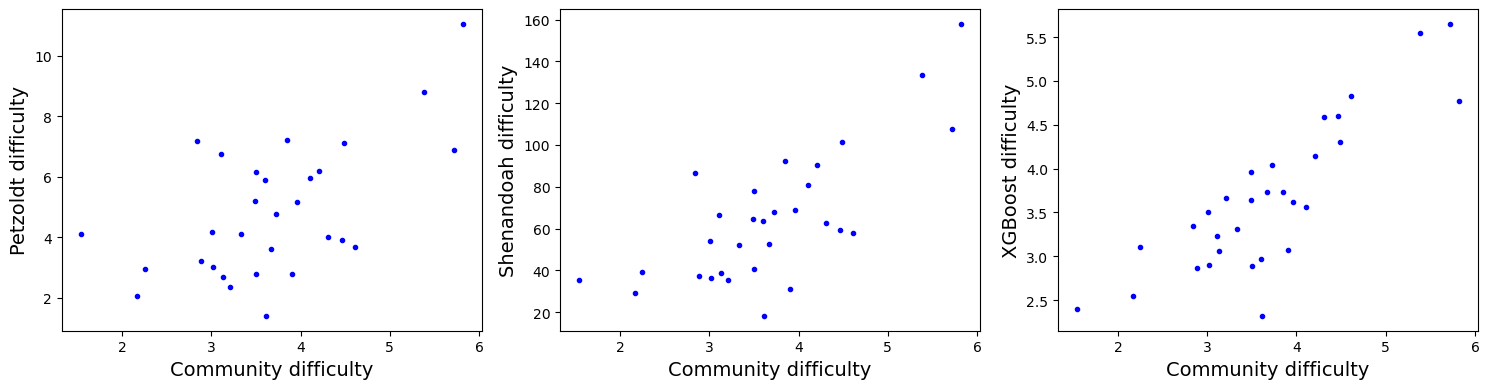

0.3501313124546653
0.5528905056257615
0.7215095777401687


In [15]:
preds_petzoldt=np.asarray(df_test['Length']+df_test['Elevation gain']/500)
preds_shenandoah=np.asarray((2*df_test['Elevation gain']*df_test['Length'])**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15,4))

ax1.plot(y_test, preds_petzoldt, 'b.')
ax1.set_xlabel('Community difficulty',fontsize=14)
ax1.set_ylabel('Petzoldt difficulty',fontsize=14)

ax2.plot(y_test, preds_shenandoah, 'b.')
ax2.set_xlabel('Community difficulty',fontsize=14)
ax2.set_ylabel('Shenandoah difficulty',fontsize=14)

ax3.plot(y_test, preds_test, 'b.')
ax3.set_xlabel('Community difficulty',fontsize=14)
ax3.set_ylabel('XGBoost difficulty',fontsize=14)

plt.tight_layout()
plt.show()

from scipy.stats import pearsonr

r2_petzoldt=pearsonr(preds_petzoldt,y_test)[0]**2
r2_shenandoah=pearsonr(preds_shenandoah,y_test)[0]**2
r2_xgb=pearsonr(preds_test,y_test)[0]**2

print(r2_petzoldt)
print(r2_shenandoah)
print(r2_xgb)

Both the r<sup>2</sup> values and the plots show a tighter relationship between the XGBoost predictions and the target values compared to the analytical approaches. However, one could object that we shouldn't assume that the correlations between the analytical formulae and the target difficulty values will be linear in nature. To address this critique, we'll compute the distance correlation between each of the prediction methods and the difficulty values. Unlike Pearson correlations, distance correlations capture both linear and nonlinear associations between variables.

In [16]:
import dcor

dcor_petzoldt=dcor.distance_correlation(preds_petzoldt,y_test)
dcor_shenandoah=dcor.distance_correlation(preds_shenandoah,y_test)
dcor_xgb=dcor.distance_correlation(preds_test,y_test)

print(dcor_petzoldt)
print(dcor_shenandoah)
print(dcor_xgb)

0.5485211543607802
0.7160623569889812
0.8405137142776584


C:\Users\marsh\anaconda3\Lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Our XGBoost model has a significantly higher distance correlation with respect to the targets compared to the Petzoldt and Shenandoah measures. Thus, we are justified in saying that our XGBoost model is a stronger predictor of hike difficulty (as rated by the community) compared to the Petzoldt and Shenandoah measures. Granted, our model is a much more complex approach since it considers more features and is highly nonlinear in nature; however, recall that all of the features used to train the model were compiled from publicly-available resources. Thus, extending this modeling approach to more trails should be straightforward in nature. It is also likely to improve in accuracy as the size of the training dataset grows.